In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
import trilearn.graph.graph as glib
import itertools as its
import trilearn.graph.junction_tree as jtlib
import trilearn.graph.decomposable as dlib
import trilearn.mh_greenthomas as gt
import copy

In [5]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return its.chain.from_iterable(its.combinations(s, r) for r in range(len(s)+1))

def edges_powerset(p):
    "return all graphs of size p"
    return list(its.combinations(list(range(p)), 2))


def hash_graph(G):
    "hashing a graph by ordering the edge set"
    ed = [tuple(sorted(e)) for e in G.edges()]
    return hash(str(sorted(ed)))


def count_decomposable_graphs(size, traj, decomp_index_table):
    "counting the number of decomposable graphs"
    p = size
    graph_dict = copy.deepcopy(decomp_index_table)
    prev_hash = None # to remove repeated graph, where no traj changes
    for g in traj:
        if not g:
            continue
        b = hash_graph(g)
        if b == prev_hash:
            continue
        prev_hash = b
        c = graph_dict[b]['count']
        graph_dict[b]['count'] = 1 + c
                                
    return graph_dict


def pdf_plot(x):
    "plotting the probability density function"
    a = float(np.sum(x))
    b = np.cumsum(x)
    ax = pd.Series(b/a).plot(label='empirical')
    plt.plot([0, 1], [0, 1], transform=ax.transAxes, label='theoratical')
    plt.xlabel("Decomposable graphs (ordered from highest by no. junction trees)")
    plt.ylabel("Cumulative probability")


    
def filter_decomposable_graphs(graphs, graph_size):
    """ returns decomposable graphs out of powerset of graphs 
        and numer of junction trees per graph
    """
    decomp = dict()
    
    for a in graphs:
        a = list(a)
        G = nx.Graph()
        G.add_nodes_from(range(graph_size))
        G.add_edges_from(a)
        if nx.is_chordal(G): 
            b = hash_graph(G)
            n_jt = dlib.n_junction_trees(G)
            decomp[b] = {'count': 0, 'nedges': G.size(),
                         'g': a,
                         'n_jt':
                         n_jt, 'nnodes': graph_size}
        G.clear()
    return decomp



## Generating index table of decomposbale graphs of fixed size

In [3]:
tic = time.time()
graph_size = 6
all_edges = edges_powerset(graph_size)
all_graphs_of_size_p = list(powerset(all_edges))
decomp_table = filter_decomposable_graphs(all_graphs_of_size_p, graph_size)
print("#.all graph {}, #.decomp graphs {} of {} nodes".format(len(all_graphs_of_size_p), 
                                                              len(decomp_table), 
                                                              graph_size))
toc = time.time()
print('time took {:.2f}sec'.format(toc - tic))

#.all graph 32768, #.decomp graphs 18154 of 6 nodes
time took 18.19sec


Metropolis-Hastings samples: 100%|██████████| 99999/99999 [00:42<00:00, 2327.34it/s]


time took 42.98sec


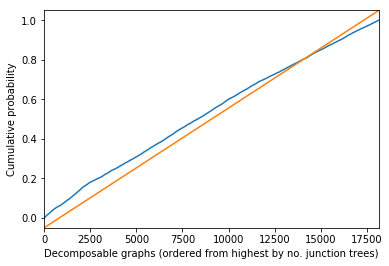

In [4]:
n_samples = 100000
randomize = 100
graph_size = 6
tic = time.time()
np.random.seed(2)
traj = gt.sample_trajectory_uniform(n_samples=n_samples,randomize=randomize, graph_size=graph_size)
toc = time.time()                     
print('time took {:.2f}sec'.format(toc - tic))    
gt_count = count_decomposable_graphs(graph_size, 
                                     traj.trajectory,
                                     decomp_table)
df = pd.DataFrame.from_dict(gt_count,orient='index').sort_values(by = 'n_jt', ascending=False)
pdf_plot(df['count'].values)